# Learning the Gaussian Curve

In the notebook implementing the basic back propagation algorithm from scratch, I used as an example case of learning a gaussian curve. In theory, our model should be able to learn this well since there is no noise in the model (we are learning a deterministic function).

I will explore more robust approaches in deep learning to properly learn this gaussian curve. Some ideas I will try:

- Use more data
- Hyper-Parameter Testing
  - Number and Shape of Layers in the Network
  - Learning Rate
- Better Training Procedure: will use the Adam Algorithm instead of SGD


In [63]:
import numpy as np
import math
import matplotlib.pyplot as plt

from random import random

## Defining a Gaussian Curve

In [14]:
def create_gaussian_curve(mean, variance, delta=0.2):
    std = math.sqrt(variance)
    normalize = 1 / (std * math.sqrt(2 * 3.14159))

    def gaussian_curve(x, y):
        term = (x - mean) / std
        expected = normalize * np.exp(-1/2 * term * term)
        return 1 if abs(expected - y) <= delta else 0
    
    return gaussian_curve


In [15]:
num_points = 1000000

In [16]:
gauss_func = create_gaussian_curve(0.0, 0.05)
points = np.random.rand(2, num_points) * 4 - 2
labels = np.apply_along_axis(lambda x: gauss_func(x[0], x[1]), axis=0, arr=points)

random_assignment = np.random.rand(num_points)
train_mask = random_assignment <= 0.8
valid_mask = (random_assignment > 0.8) & (random_assignment <= 0.9)
test_mask = random_assignment > 0.9

train_data = points[:, train_mask]
train_labels = labels[train_mask]

valid_data = points[:, valid_mask]
valid_labels = labels[valid_mask]

test_data = points[:, test_mask]
test_labels = labels[test_mask]

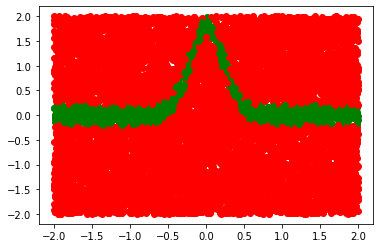

In [25]:
# Let's make a plot to see where the curve is being drawn.
# We will look at the first 5,000 points.

for i in range(5000):
    point = train_data[:, i]
    label = train_labels[i]
    plt.plot(point[0], point[1], 'go' if label == 1 else 'ro')

plt.show()

## Defining the Model

### Activation Functions

In [ ]:
def relu(X):
    mask = X >= 0
    return X * mask


In [ ]:
def relu_deriv(X):
    return (X >= 0).astype(float)


In [ ]:
def sigmoid(X):
    return 1. / (1 + np.exp(-X))


In [ ]:
def sigmoid_deriv(X):
    sig = sigmoid(X)
    return sig * (1 - sig)


### Loss Functions

In [ ]:
def binary_cross_entropy_loss(output, expected):
    # Note that this function will throw errors if any of the output
    # values are 0 or 1 exactly.
    m = output.shape[1]

    # Offset the output if there are any values exactly equal to
    # zero or one to avoid log(0).
    zero_correct = (output == 0).astype(float) * 1e-10 
    one_correct = (output == 1).astype(float) * (-1e-10)
    output = output + zero_correct + one_correct

    return np.sum((expected * -np.log(output)) + (1 - expected) * -np.log(1 - output)) / m


In [ ]:
def binary_cross_entropy_loss_grad(output, expected):
    # Note that this function will throw errors if any output is 0.
    m = output.shape[1]
    return (1. / m) * ((expected / output) - (1 - expected) / (1 - output))


### Random Initialization

In [20]:
# Note: When initializing the layers, we will assume that the output
# layer is always a single output through a sigmoid activation.
def xavier_initialization(input_size, layer_sizes):
    layers = []
    
    prev_layer_size = input_size

    for size in layer_sizes:
        normalize = 1. / math.sqrt(prev_layer_size)
        weights = np.random.randn(size, prev_layer_size) * normalize
        biases = np.random.randn(size, 1) * normalize
        layers.append((weights, biases))

        prev_layer_size = size
        
    # Add a final output layer for sigmoid activation.
    weights = np.random.randn(1, prev_layer_size)
    biases = np.random.randn(1, 1)
    layers.append((weights, biases))
    
    return layers


### Model Functions

In [21]:
def forward(model, X):
    Y = X

    linear_outputs = []
    outputs = []

    for (i, (weights, biases)) in enumerate(model['layers'][0:-1]):
        Y = np.dot(weights, Y) + biases
        linear_outputs.append(Y)

        Y = relu(Y)
        outputs.append(Y)
        

    # Note: Last layer is processed by sigmoid activation.
    weights, biases = model['layers'][-1]

    Y = np.dot(weights, Y) + biases
    linear_outputs.append(Y)

    Y = sigmoid(Y)
    outputs.append(Y)

    # Save the results of the forward pass so we can do a backward
    # pass on them later.
    if 'no_grad' not in model or not model['no_grad']:
        model['linear_outputs'] = linear_outputs
        model['input'] = X
        model['outputs'] = outputs
        model['result'] = Y

    return Y
 

In [22]:
def backward(model, expected):
    # Note: We are assuming the model has already gone through a
    # forward pass.

    layers = model['layers']
    linear_outputs = model['linear_outputs']
    outputs = model['outputs']
    X = model['input']
    result = model['result']

    L = len(layers)
    m = result.shape[1] # Number of samples.

    # Note: We can have multiple samples in the outputs, so we
    # will end up with a gradient per sample.
    output_prev_layer = X if len(outputs) <= 1 else outputs[-2]
    loss_grad = binary_cross_entropy_loss_grad(result, expected)
    error_last_layer = loss_grad * sigmoid_deriv(linear_outputs[-1])
    bias_grad_last_layer = np.sum(error_last_layer, axis=1).reshape(-1, 1)
    weights_grad_last_layer = np.dot(error_last_layer, output_prev_layer.T) # outer product
    grad_last_layer = (weights_grad_last_layer, bias_grad_last_layer)

    errors = [error_last_layer]
    grads = [grad_last_layer]
    
    # Enumerate layers in reverse order to compute errors
    # and gradients.
    for i in range(L - 2, -1, -1):
        linear_output = linear_outputs[i]
        output_prev_layer = X if i == 0 else outputs[i-1]
        error_next_layer = errors[-1]
        weights_next_layer, bias_next_layer = layers[i+1]

        error = np.dot(weights_next_layer.T, error_next_layer) * sigmoid_deriv(linear_output)
        bias_grad = np.sum(error, axis=1).reshape(-1, 1)
        weights_grad = np.dot(error, output_prev_layer.T)
        
        errors.append(error)
        grads.append((weights_grad, bias_grad))
        
    # Reverse the order of errors and gradients so they go from
    # first layer to last.
    errors.reverse()
    grads.reverse()
    
    if 'no_grad' not in model or not model['no_grad']:
        model['errors'] = errors
        model['grads'] = grads
    
    return grads, errors


In [23]:
def no_grad(model):
    model['no_grad'] = True


In [24]:
def grad(model):
    model['no_grad'] = False


### Gradient Update

In [26]:
def step_SGD(model, lr=0.1):
    # Note: We are assuming the model has already gone
    # through back propagation and all the gradients have
    # been calculated.
    
    new_layers = []

    for (i, layer) in enumerate(model['layers']):
        weight, bias = layer
        grad_weight, grad_bias = model['grads'][i]
        
        weight = weight + (lr * grad_weight)
        bias = bias + (lr * grad_bias)

        model['layers'][i] = (weight, bias)


In [27]:
def step_Adam(model, lr=0.1):
    pass
    # TODO: HERE I AM! NEED TO DEFINE ADAM OPTIMIZER!


## Creating and Training Model

In [30]:
def create_model(layers, learning_rate):
    pass

In [29]:
def train_model(train_data, train_labels, epochs=1000, logs=True):
    pass

### Defining Hyper Parameters

In [67]:
learning_rates = np.logspace(-1, -6, num=5)

layer_sizes_list = [
    [4],
    [3],
    [4, 3],
    [3, 4],
    [6, 4],
    [4, 6],
    [6, 4, 3],
    [3, 4, 6],
]


We currently have 40 unique combinations of hyper parameters, which is too much. We will randomly sample 10 of those 40 hyper parameter settings to try out.

In [68]:
import random

In [73]:
# Note that it is possible we could end up testing the same hyper parameter settings
# multiple times. We won't correct for this.

hyperparams = []

for i in range(10):
    lr = learning_rates[int(math.floor(len(learning_rates) * random.random()))]
    layer_sizes = layer_sizes_list[int(math.floor(len(layer_sizes_list) * random.random()))]
    hyperparams.append({'lr': lr, 'layer_sizes': layer_sizes})


[{'lr': 1.778279410038923e-05, 'layer_sizes': [3, 4, 6]},
 {'lr': 1.778279410038923e-05, 'layer_sizes': [3, 4, 6]},
 {'lr': 0.00031622776601683794, 'layer_sizes': [6, 4]},
 {'lr': 0.005623413251903491, 'layer_sizes': [4]},
 {'lr': 1.778279410038923e-05, 'layer_sizes': [3, 4]},
 {'lr': 0.1, 'layer_sizes': [4, 6]},
 {'lr': 0.005623413251903491, 'layer_sizes': [4, 6]},
 {'lr': 1.778279410038923e-05, 'layer_sizes': [4, 6]},
 {'lr': 1e-06, 'layer_sizes': [4, 3]},
 {'lr': 0.1, 'layer_sizes': [4]}]